In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

In [28]:
df=pd.read_excel("DSE13-21.xlsx")
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
1926,2013-02-05,4191.50,4191.50,4191.50,4191.50,-,0.0065
1927,2013-02-04,4164.62,4164.62,4164.62,4164.62,-,0.0002
1928,2013-02-03,4163.82,4163.82,4163.82,4163.82,-,0.0067
1929,2013-01-31,4136.30,4136.30,4136.30,4136.30,-,0.0023
1930,2013-01-30,4126.75,4126.75,4126.75,4126.75,-,-0.0067


#### Analyze the closing prices from dataframe: 

In [29]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

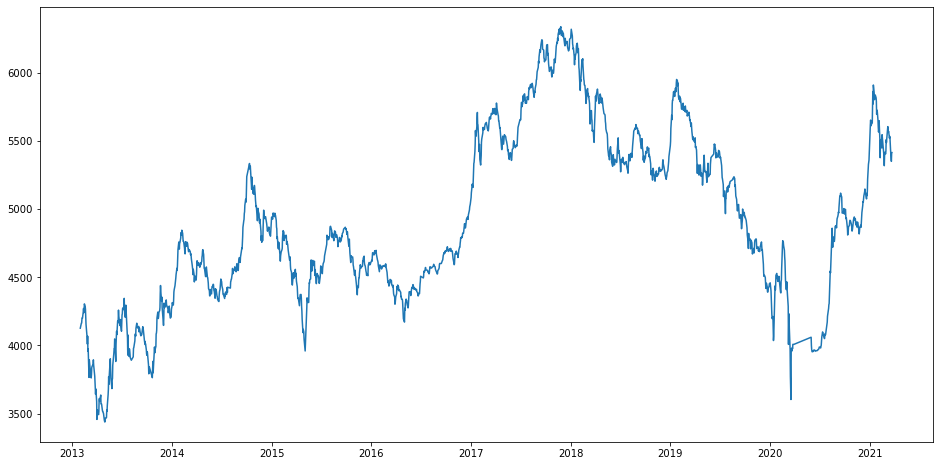

In [30]:
#plot
plt.figure(figsize=(16,8))
plt.plot(df['Price'], label='Close Price history')

#### Sort the dataset on date time and filter “Date” and “Close” columns: 

In [31]:
#setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Price'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Price'][i] = data['Price'][i]

In [32]:
#create features
from fastai.tabular import  add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

C:\Users\rokan\anaconda3\lib\site-packages\fastai\tabular\transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())


In [33]:
new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0

<ipython-input-33-6f8c1d8c930d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['mon_fri'][i] = 0
<ipython-input-33-6f8c1d8c930d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['mon_fri'][i] = 1


#### Normalize the new filtered dataset: 

In [7]:
!pip install pmdarima

  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.0
    Uninstalling statsmodels-0.12.0:
      Successfully uninstalled statsmodels-0.12.0


In [34]:
from pmdarima.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = data[:1600]
valid = data[1600:]

training = train['Price']
validation = valid['Price']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=331)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=7.74 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=17072.106, Time=0.14 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=16610.270, Time=1.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=17037.211, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=16401.618, Time=3.57 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=11.09 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.07 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=16436.482, Time=2.45 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=16402.257, Time=4.37 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=16400.627, Time=10.20 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=4.84 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=16.43 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=5.96 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1

In [35]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Price'])-np.array(forecast['Prediction'])),2)))
rms

960.7521796937094

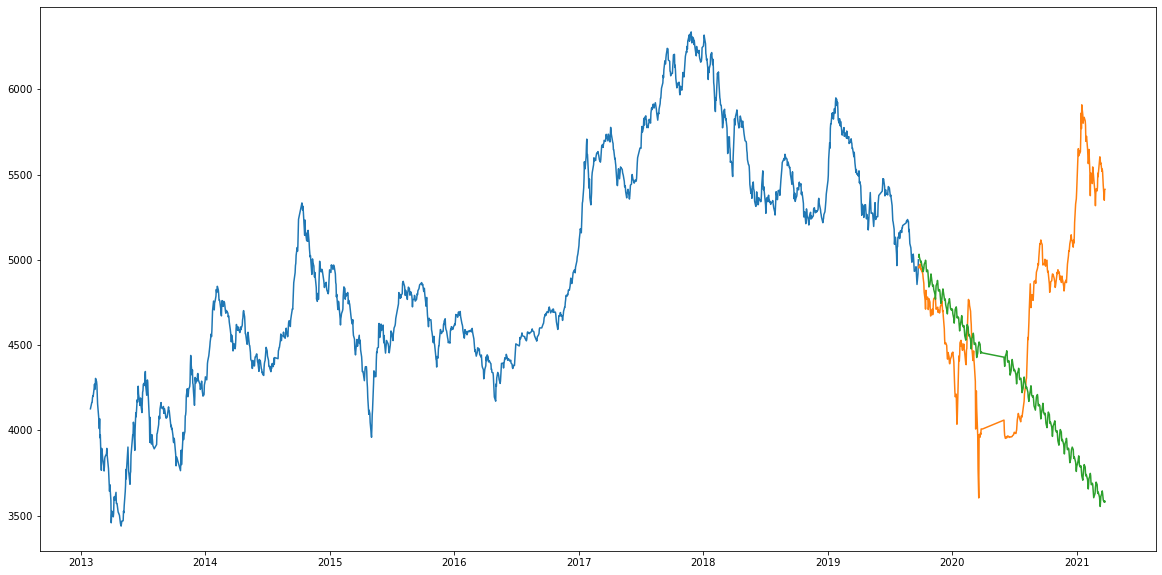

In [36]:
#plot
plt.plot(train['Price'])
plt.plot(valid['Price'])
plt.plot(forecast['Prediction'])